## Scenario
**Nate Silver and co. at FiveThirtyEight have agreed to hear my pitch for a story in two weeks!
Your piece is going to be on how to create a Reddit post that will get the most engagement
from Reddit users. Because this is FiveThirtyEight, you're going to have to get data and 
analyze it in order to make a compelling narrative.**

There are two major tasks involved:
- Collecting data by scraping a website 
- building a binary predictor.


## Problem statement is: 
- **What characteristics of a post on Reddit are most predictive of the overall interaction on a thread (as measured by number of comments)?**

### Method for acquiring the data will be -*scraping the 'hot' threads as listed on the Reddit homepage.*

We need to build a classification model that, using Natural Language Processing and any
other relevant features, predicts whether or not a given Reddit post will have above or 
below the median number of comments.

We start by importing libraries.

In [126]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, 
                            confusion_matrix, 
                            classification_report,
                            plot_confusion_matrix)
from sklearn.model_selection import StratifiedKFold

from nltk.stem.snowball import SnowballStemmer

import nltk
from nltk.corpus import stopwords, wordnet
stop_words = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score

In [2]:
df = pd.read_csv('Data/reddit_hot_posts.csv')

In [3]:
df.head()

,post_id,author_comment_karma,author_link_karma,time_in_mins,post_is_original_content,post_name,post_num_comments,post_over_18,post_score,post_has_link,post_spoiler,post_stickied,subreddit_id,subreddit_name,subreddit_subscriber_count,post_title,post_upvote_ratio,post_url,subreddit_display_name
0,uz8935,15541,60892,665,False,t3_uz8935,842,False,47197,False,False,False,35n7t,t5_35n7t,2536337,Cops don't help,0.94,https://i.redd.it/hmyphrd963291.jpg,WhitePeopleTwitter
1,uz7wjk,58678,6272,682,False,t3_uz7wjk,2007,False,20288,False,False,False,2qh3l,t5_2qh3l,24719676,Uvalde school police chief identified as comma...,0.97,https://www.cnn.com/us/live-news/texas-element...,news
2,uz88xi,3302,6450,666,False,t3_uz88xi,988,False,13857,False,False,False,2qnts,t5_2qnts,21410219,Police didn't immediately confront the gunman ...,0.97,https://www.insider.com/texas-shooting-police-...,nottheonion
3,uz6jv0,230,6754,748,False,t3_uz6jv0,555,False,20928,False,False,False,35fmc,t5_35fmc,2315682,Customer is upset that a mattress store won’t…...,0.97,https://i.redd.it/p1tbj9lnr2291.jpg,ChoosingBeggars
4,uz626e,28965,6418,772,False,t3_uz626e,897,False,26027,False,False,False,2y77d,t5_2y77d,1956757,Cops trying to join the movement.,0.95,https://i.redd.it/zsbadixgn2291.jpg,antiwork


In [4]:
df.shape

(11353, 19)

In [5]:
df.isnull().sum() #no nulls in any columns

post_id                       0
author_comment_karma          0
author_link_karma             0
time_in_mins                  0
post_is_original_content      0
post_name                     0
post_num_comments             0
post_over_18                  0
post_score                    0
post_has_link                 0
post_spoiler                  0
post_stickied                 0
subreddit_id                  0
subreddit_name                0
subreddit_subscriber_count    0
post_title                    0
post_upvote_ratio             0
post_url                      0
subreddit_display_name        0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11353 entries, 0 to 11352
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   post_id                     11353 non-null  object 
 1   author_comment_karma        11353 non-null  int64  
 2   author_link_karma           11353 non-null  int64  
 3   time_in_mins                11353 non-null  int64  
 4   post_is_original_content    11353 non-null  bool   
 5   post_name                   11353 non-null  object 
 6   post_num_comments           11353 non-null  int64  
 7   post_over_18                11353 non-null  bool   
 8   post_score                  11353 non-null  int64  
 9   post_has_link               11353 non-null  bool   
 10  post_spoiler                11353 non-null  bool   
 11  post_stickied               11353 non-null  bool   
 12  subreddit_id                11353 non-null  object 
 13  subreddit_name              113

In [7]:
df.describe()

,author_comment_karma,author_link_karma,time_in_mins,post_num_comments,post_score,subreddit_subscriber_count,post_upvote_ratio
count,1.135300e+04,1.135300e+04,11353.000000,11353.000000,11353.000000,1.135300e+04,11353.000000
mean,3.339496e+04,2.901221e+05,896.755483,130.529023,3403.962389,1.904541e+06,0.966678
std,1.457475e+05,1.529299e+06,274.322630,477.287683,8157.792062,5.000029e+06,0.035462
min,-1.000000e+02,3.500000e+01,1.000000,0.000000,68.000000,9.600000e+02,0.590000
25%,4.960000e+02,2.689000e+03,739.000000,15.000000,457.000000,1.366720e+05,0.960000
50%,3.480000e+03,1.132000e+04,896.000000,38.000000,1051.000000,3.814780e+05,0.980000
75%,1.766600e+04,5.824000e+04,1086.000000,103.000000,2760.000000,1.219771e+06,0.990000
max,4.625719e+06,3.952919e+07,1440.000000,19438.000000,213558.000000,4.087651e+07,1.000000


## Creating a new binary variable target

We want to predict a binary variable our target variable, to know whether the number of comments was low or high. For that we:
- Compute the median number of comments and create a new binary target variable that is true when the number of comments is greater than the median).
- We convert this into a _binary_ classification problem, by predicting two classes, high vs low number of comments.

In [8]:
median_number_comments = np.median(df['post_num_comments'])

In [9]:
df['target'] = [1 if entry>median_number_comments else 0 for entry in df.post_num_comments]

## Creating explicit binary columns for boolean columns

We want to convert booleans into 1 and 0 explicitly for ease of computation

In [10]:
df['post_is_original_content'] = [1 if entry == True else 0 for entry in df['post_is_original_content']]

In [11]:
df['post_over_18'] = [1 if entry ==True else 0 for entry in df['post_over_18']]

In [12]:
df['post_has_link'] =[1 if entry ==True else 0 for entry in df['post_has_link']]

In [13]:
df['post_spoiler'] = [1 if entry ==True else 0 for entry in df['post_spoiler']]

In [14]:
df['post_stickied'] = [1 if entry ==True else 0 for entry in df['post_stickied']]

**We are dropping subreddit_name, subreddit_id, post_name and post_url as they seem irrelevant for computational purposes**

In [15]:
df.drop(columns=['subreddit_name','subreddit_id','post_name','post_url'], inplace=True)

In [16]:
df.head()

,post_id,author_comment_karma,author_link_karma,time_in_mins,post_is_original_content,post_num_comments,post_over_18,post_score,post_has_link,post_spoiler,post_stickied,subreddit_subscriber_count,post_title,post_upvote_ratio,subreddit_display_name,target
0,uz8935,15541,60892,665,0,842,0,47197,0,0,0,2536337,Cops don't help,0.94,WhitePeopleTwitter,1
1,uz7wjk,58678,6272,682,0,2007,0,20288,0,0,0,24719676,Uvalde school police chief identified as comma...,0.97,news,1
2,uz88xi,3302,6450,666,0,988,0,13857,0,0,0,21410219,Police didn't immediately confront the gunman ...,0.97,nottheonion,1
3,uz6jv0,230,6754,748,0,555,0,20928,0,0,0,2315682,Customer is upset that a mattress store won’t…...,0.97,ChoosingBeggars,1
4,uz626e,28965,6418,772,0,897,0,26027,0,0,0,1956757,Cops trying to join the movement.,0.95,antiwork,1


## Creating a variable title_length=word count of post_title

In [17]:
df['title_length'] = [len(entry.strip().split()) for entry in df.post_title]

## Dropping Duplicates

In [18]:
df[df["post_title"].duplicated()].shape

(395, 17)

In [19]:
df=df.drop_duplicates(keep='first',subset='post_title')
df.shape

(10958, 17)

**Droppping post_id by manipulation**

In [20]:
df.set_index('post_id',inplace=True)
df.reset_index(inplace=True,drop=True)


In [21]:
df.head()

,author_comment_karma,author_link_karma,time_in_mins,post_is_original_content,post_num_comments,post_over_18,post_score,post_has_link,post_spoiler,post_stickied,subreddit_subscriber_count,post_title,post_upvote_ratio,subreddit_display_name,target,title_length
0,15541,60892,665,0,842,0,47197,0,0,0,2536337,Cops don't help,0.94,WhitePeopleTwitter,1,3
1,58678,6272,682,0,2007,0,20288,0,0,0,24719676,Uvalde school police chief identified as comma...,0.97,news,1,13
2,3302,6450,666,0,988,0,13857,0,0,0,21410219,Police didn't immediately confront the gunman ...,0.97,nottheonion,1,16
3,230,6754,748,0,555,0,20928,0,0,0,2315682,Customer is upset that a mattress store won’t…...,0.97,ChoosingBeggars,1,11
4,28965,6418,772,0,897,0,26027,0,0,0,1956757,Cops trying to join the movement.,0.95,antiwork,1,6


In [22]:
df.to_csv('Data/Data before preprocessing.csv')

## Preprocessing

> Preprocessing codified in various functions

In [23]:
# Function to remove noise from text and deal with negation
def cleaning_data(comment):
    
    #Remove Non-ASCII characters
    comment = re.sub(r"\xa0",r" ",comment)
    comment = comment.encode("ascii", errors="ignore").decode()
    
    #Lower case the data
    comment = comment.lower()
    
    #Remove HTML Links
    comment = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', comment)   
    comment = re.sub(r'\n','',comment)
    
    #Cleaning the data by removing special characters
    comment = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", comment)
    
     #Handling negations
    comment = re.sub(r"youtu.be", " youtube", comment)
    comment = re.sub(r"https", " http", comment)
    comment = re.sub(r"i'm", " i am", comment)
    comment = re.sub(r"it's", " it is", comment)
    comment = re.sub(r"ain't", "is not",comment)
    comment = re.sub(r"aren't", "are not",comment)
    comment = re.sub(r"couldn't", "could not",comment)
    comment = re.sub(r"didnt", "did not",comment)
    comment = re.sub(r"dont", "do not",comment)
    comment = re.sub(r"doesn't", "does not",comment)
    comment = re.sub(r"hadn't", "had not",comment)
    comment = re.sub(r"hasn't", "has not",comment)
    comment = re.sub(r"haven't", "have not",comment)
    comment = re.sub(r"isn't", "is not",comment)
    comment = re.sub(r"shouldn't", "should not",comment)
    comment = re.sub(r"shan't", "shall not",comment)
    comment = re.sub(r"wasn't", "was not",comment)
    comment = re.sub(r"weren't", "were not",comment)
    comment = re.sub(r"oughtn't", "ought not",comment)
    comment = re.sub(r"that's", " that is", comment)
    comment = re.sub(r"\'s", " ", comment)
    comment = re.sub(r"\'ve", " have", comment)
    comment = re.sub(r"won't", " will not", comment)
    comment = re.sub(r"wouldn't", " would not", comment)
    comment = re.sub(r"don't", " do not", comment)
    comment = re.sub(r"can't", " can not", comment)
    comment = re.sub(r"cannot", " can not", comment)
    comment = re.sub(r"n\'t", " n\'t", comment)
    comment = re.sub(r"\'re", " are", comment)
    comment = re.sub(r"\'d", " would", comment)
    comment = re.sub(r"\'ll", " will", comment)    
    comment = re.sub(r"!", " ! ", comment)
    comment = re.sub(r"\?", " ? ", comment)
    comment = re.sub(r"\s{2,}", " ", comment)
    
    # Removing all the numbers
    comment = re.sub(r'[0-9]+', ' ', comment)
    
    #Removing all puncs
    comment = re.sub(r'[^\w\s]','',comment)
    
    # Substituting multiple spaces with single space
    comment = re.sub(r'\s+', ' ', comment, flags=re.I)
    
    # Remove single letters
    comment= re.sub(r"\b[a-zA-Z]\b","", comment)
        
    comment = [word for word in comment.split() if len(word) >= 2]
    comment = ' '.join(comment)
    
    return comment
  
#Removing the stop words
def stopwords_data(comment):
    more_stop_words = ["wa", "gt","amp", "u", "ha", "le", "doe", "don",'ve']
    stop_words_ = stop_words.union(more_stop_words)
    comment = [word for word in comment.split() if not word in stop_words_]
    comment = ' '.join(comment)           
    return comment
  
#Tag words by their parts of speech 
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

#Normalising the data by lemmatizing
def lemmatize_data(comment):
    comment = [lemmatizer.lemmatize(word,get_wordnet_pos(word)) for word in comment.split()]
    comment = ' '.join(comment)
    comment = [word for word in comment.split() if len(word) >= 3]
    comment = ' '.join(comment)
    return comment

#Normalise data by user-defined stemming
def stem(word):
    for suffix in ['ing', 'ly', 'ed', 'ious', 'ies', 'ive', 'es', 's', 'ment']:
        if word.endswith(suffix):
            return word[:-len(suffix)]
    return word

def stemmer(phrase):
    r=[]
    for word in phrase.split():
        r.append(stem(word))
    return ' '.join(r)
  
#Normalising the data by renowned stemming methods

stemmer=SnowballStemmer('english')
def stem_data(comment):
    comment = [stemmer.stem(word) for word in comment.split()]
    comment = ' '.join(comment)
    comment = [word for word in comment.split() if len(word) >= 3]
    comment = ' '.join(comment)
    return comment

#list of cleaned words
def cleandata(X_datatrain, X_datatest):
    cleandata_Train = []
    for sen in range(0, len(X_datatrain)): 
        cleandata_Train.append(preprocess_data(str(X_datatrain[sen])))
        
    cleandata_Test = []
    for sen in range(0, len(X_datatest)): 
        cleandata_Test.append(preprocess_data(str(X_datatest[sen])))
    return cleandata_Train, cleandata_Test

In [24]:
#Preprocessing the data
def preprocess_data(review):
    document = cleaning_data(review)
    document = stopwords_data(document)
    document = lemmatize_data(document)
    document = stem_data(document)
    
    return document 

> Preprocessing applied on post_title

In [25]:
print("Cleaning of Training data on process...")
df['post_title_processed'] = df['post_title'].apply(preprocess_data)
print("Task completed")

Cleaning of Training data on process...
Task completed


## Graphs

### word length count

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


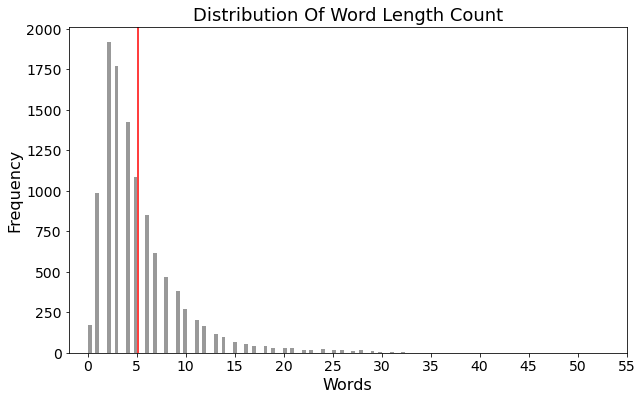

In [26]:
# Generating a list of text lengths

lengths = [len(text.strip().split()) for text in df["post_title_processed"]]

# Plotting the text lengths

plt.figure(figsize = (10,6), facecolor = "white")
sns.distplot(lengths, kde = False, bins = 100, color = "black")
plt.axvline(np.mean(lengths), color = "red")
plt.title("Distribution Of Word Length Count", size = 18)
plt.xlabel("Words", size = 16)
plt.ylabel("Frequency", size = 16)
plt.xticks(np.arange(0,60,5), size = 14)
plt.yticks(size = 14);

# The red line marks the mean length

### subreddit_count

In [27]:
subreddit_count = pd.DataFrame(df['subreddit_display_name'].value_counts().head(10))
subreddit_count

,subreddit_display_name
WhitePeopleTwitter,25
memes,24
aww,23
worldnews,22
Superstonk,22
politics,22
interestingasfuck,22
gaming,21
formula1,21
MadeMeSmile,21


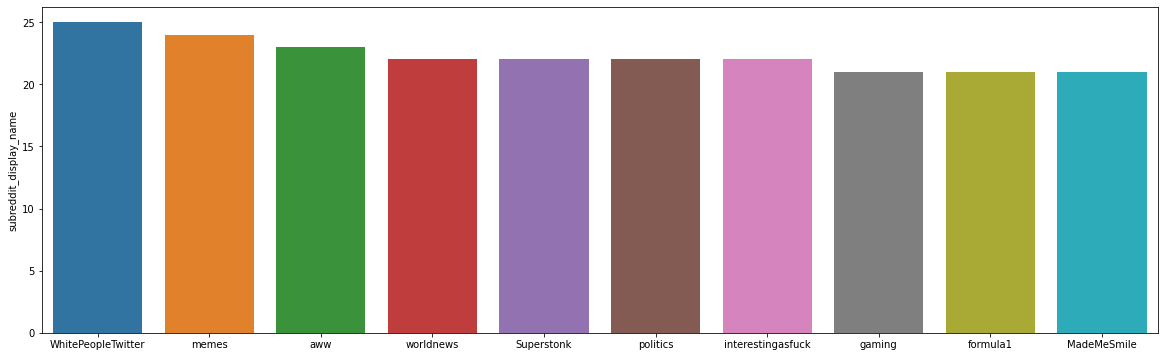

In [28]:
fig,ax=plt.subplots(figsize=(20,6))
sns.barplot(y='subreddit_display_name', x=subreddit_count.index, data=subreddit_count);

In [ ]:
fig,ax=plt.subplots(figsize=(20,6))
df['post_num_comments'].hist()

## What is the baseline accuracy ?

In [29]:
baseline = np.mean(df['target'])
print("The baseline accuracy is",baseline)

The baseline accuracy is 0.5013688629311919


## Creating dummies for subreddit_display_name
**Resulting dataframe is df_subreddit_dummies**

In [30]:
# dataframe with dummies for subreddit_display_names
df_subreddit_dummies= pd.get_dummies(df,columns=['subreddit_display_name'],prefix='subreddit',drop_first=True)

In [31]:
df_subreddit_dummies.head()

,author_comment_karma,author_link_karma,time_in_mins,post_is_original_content,post_num_comments,post_over_18,post_score,post_has_link,post_spoiler,post_stickied,...,subreddit_yeezys,subreddit_yesyesyesno,subreddit_yesyesyesyesno,subreddit_youdontsurf,subreddit_youngpeopleyoutube,subreddit_yourmomshousepodcast,subreddit_youtube,subreddit_youtubehaiku,subreddit_yugioh,subreddit_zelda
0,15541,60892,665,0,842,0,47197,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,58678,6272,682,0,2007,0,20288,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3302,6450,666,0,988,0,13857,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,230,6754,748,0,555,0,20928,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,28965,6418,772,0,897,0,26027,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## CountVectorizer

In [32]:
cvec = CountVectorizer(stop_words='english', max_features=100, max_df=0.5)
cvec_X_data = cvec.fit_transform(df['post_title_processed'])
cvec_X  = pd.DataFrame(cvec_X_data.todense(),
                   columns=cvec.get_feature_names_out())

In [33]:
cvec_X.head()

,actual,ago,alway,anim,anyon,art,ask,away,babi,bad,...,video,wait,want,war,way,week,woman,work,world,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
cvec_X.columns

Index(['actual', 'ago', 'alway', 'anim', 'anyon', 'art', 'ask', 'away', 'babi',
       'bad', 'best', 'big', 'boy', 'cat', 'chang', 'child', 'come', 'cosplay',
       'day', 'dog', 'end', 'everi', 'fan', 'favorit', 'feel', 'final',
       'friend', 'fuck', 'game', 'girl', 'good', 'great', 'gun', 'guy', 'hand',
       'happi', 'hate', 'help', 'home', 'hope', 'hous', 'kid', 'kill', 'know',
       'let', 'life', 'like', 'littl', 'live', 'long', 'look', 'lose', 'love',
       'make', 'man', 'meme', 'mom', 'month', 'need', 'new', 'night', 'old',
       'peopl', 'photo', 'play', 'pleas', 'polic', 'post', 'real', 'realli',
       'right', 'run', 'say', 'school', 'shoot', 'someon', 'someth', 'star',
       'start', 'stop', 'tell', 'thank', 'thing', 'think', 'thought', 'time',
       'today', 'tri', 'turn', 'use', 'video', 'wait', 'want', 'war', 'way',
       'week', 'woman', 'work', 'world', 'year'],
      dtype='object')

>**Deleting post_title and post_title_processed columns**

In [35]:
df_subreddit_dummies.drop(columns=['post_title', 'post_title_processed','post_num_comments'],inplace=True)

## Concatenating countvectorised dataframe with subreddit dummies

In [36]:
df_subreddit_cvec=pd.concat([df_subreddit_dummies,cvec_X], axis=1)
df_subreddit_cvec.shape
df_subreddit_cvec.head()

,author_comment_karma,author_link_karma,time_in_mins,post_is_original_content,post_over_18,post_score,post_has_link,post_spoiler,post_stickied,subreddit_subscriber_count,...,video,wait,want,war,way,week,woman,work,world,year
0,15541,60892,665,0,0,47197,0,0,0,2536337,...,0,0,0,0,0,0,0,0,0,0
1,58678,6272,682,0,0,20288,0,0,0,24719676,...,0,0,0,0,0,0,0,0,0,0
2,3302,6450,666,0,0,13857,0,0,0,21410219,...,0,0,0,0,0,0,0,0,0,0
3,230,6754,748,0,0,20928,0,0,0,2315682,...,0,0,0,0,0,0,0,0,0,0
4,28965,6418,772,0,0,26027,0,0,0,1956757,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df_subreddit_cvec.to_csv('Data/Subreddit dummies with countvector.csv')

## **Functions for models**

In [107]:
def rfscore1(df, target_col, test_size, n_estimators, max_depth):
    '''For individual parameters without gridsearching'''  
    X = df.drop(target_col, axis=1)   # define predictors
    y = df[target_col]                # defines target
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, test_size = test_size, random_state=42) # train/test split

    rf = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators)    #instantiates model

    rf.fit(X_train,y_train)      # fit the model to the training data
    
    # .score returns the mean accuracy on the test data
    
    print("The mean accuracy score is:",round(rf.score(X_test,y_test),2))
    preds = rf.predict(X_test)
    print("")
    print("Confusion Matrix:\n")
    print(pd.crosstab(pd.concat([X_test,y_test],axis=1)['target'], preds, rownames=['Actual Values'], colnames=['Predicted Values']))
    print('Features and their importance:\n')
    feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values().tail(10)
    print(feature_importances.plot(kind="barh", figsize=(6,6)))
    return 



In [133]:
def rfscore2(df,target_col,test_size,n_estimators,max_depth):
    '''Gridsearching RandomForest'''
    X = df.drop(target_col, axis=1)   # predictors
    y = df[target_col]                # target
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, test_size = test_size, random_state=42) # TT split
    rf_params = {
             'n_estimators':n_estimators,
             'max_depth':max_depth}   # parameters for grid search
    rf_gs = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, verbose=1, n_jobs=-1)
    rf_gs.fit(X_train,y_train) # training the random forest with all possible parameters
    print('GridSearch results')
    print('The best parameters on the training data are:\n',rf_gs.best_params_) # printing the best parameters
    max_depth_best = rf_gs.best_params_['max_depth']      # getting the best max_depth
    n_estimators_best = rf_gs.best_params_['n_estimators']  # getting the best n_estimators
    print("best max_depth:",max_depth_best)
    print("best n_estimators:",n_estimators_best)
    best_rf_gs = RandomForestClassifier(max_depth=max_depth_best,n_estimators=n_estimators_best) # instantiate the best model
    
    score(best_rf_gs, 'Random Forest', X_train, y_train)
    
    best_rf_gs.fit(X_train,y_train)  # fitting the best model
#     best_rf_score = best_rf_gs.score(X_test,y_test) 
#     print ("best score is:",round(best_rf_score,2))
    preds = best_rf_gs.predict(X_test)
    print("")
    
    print("Confusion Matrix:\n")
    print(confusion_matrix(y_test,preds))
    print(classification_report(y_test,preds))
    print(accuracy_score(y_test, preds))

    
#     print("Confusion Matrix:\n")
#     print(pd.crosstab(pd.concat([X_test,y_test],axis=1)['target'], preds, rownames=['Actual Values'], colnames=['Predicted Values']))
    print('Features and their importance:\n')
    feature_importances = pd.Series(best_rf_gs.feature_importances_, index=X.columns).sort_values().tail(10)
    print(feature_importances.plot(kind="barh", figsize=(6,6)))
    return 

In [130]:
def score(model, name, X, y):
    cv = StratifiedKFold(n_splits=10,
                         random_state=42,
                         shuffle=True)
    s = cross_val_score(model, X, y, cv=cv,
                        n_jobs=-1)
    print('{} Score: {:.2f} +- {:.3f}'.format(name, 
                                              s.mean(), 
                                              2 * s.std()))


In [109]:
def knnscore_gridsearch(df, target_col, test_size):
    '''Gridsearching for KNeighbors Classifier'''
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    ss= StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, test_size = test_size, random_state=42) # train/test split
    knn_params= {'n_neighbors': list(range(1, 30, 2)), 'p':[1,2]}
    X_train_sc=ss.fit_transform(X_train)
    X_test_sc= ss.transform(X_test)
    knn_gs = GridSearchCV(KNeighborsClassifier(),knn_params, cv=5, verbose=1,n_jobs=-1)
    knn_gs.fit(X_train_sc, y_train)
    print('GridSearch results')
    print('The best parameters on the training data are:\n') # printing the best parameters
    n_neighbors_best = knn_gs.best_params_['n_neighbors']      # getting the best n_neighbors
    p_best = knn_gs.best_params_['p'] # printing best p
    print("best n_neighbors:",n_neighbors_best)
    print("best p:", p_best)
    
    best_knn_gs = KNeighborsClassifier(n_neighbors=n_neighbors_best,p=p_best) # instantiate the best model
    best_knn_gs.fit(X_train_sc,y_train)  # fitting the best model
    best_knn_score = best_knn_gs.score(X_test_sc,y_test) 
    print ("best score is:",round(best_knn_score,2))
    
    preds = best_knn_gs.predict(X_test_sc)
    print("")


    disp = plot_confusion_matrix(best_knn_gs, X_test_sc, y_test)
    disp.figure_.suptitle("Confusion Matrix")
    print("Confusion matrix:\n%s" % disp.confusion_matrix)
    plt.show();


> **Model 1**: Random Forest Classifier on Count Vectorised data + subreddit dummies

The mean accuracy score is: 0.76

Confusion Matrix:

Predicted Values     0     1
Actual Values               
0                 1066   302
1                  346  1026
Features and their importance:

AxesSubplot(0.125,0.125;0.775x0.755)


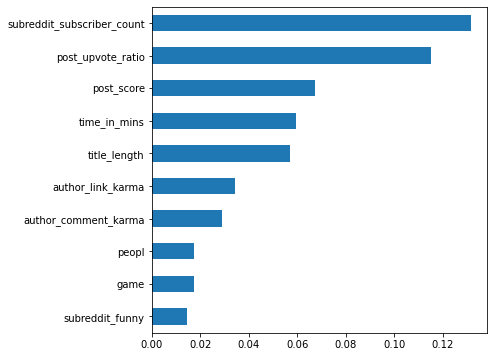

In [110]:
rfscore1(df_subreddit_cvec,'target',0.25,25,10)


> **Model 2** Gridsearch with random Forest Classifier

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
GridSearch results
The best parameters on the training data are:
 {'max_depth': 23, 'n_estimators': 110}
best max_depth: 23
best n_estimators: 110
Random Forest Score: 0.78 +- 0.036

Confusion Matrix:

[[1078  290]
 [ 298 1074]]
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1368
           1       0.79      0.78      0.79      1372

    accuracy                           0.79      2740
   macro avg       0.79      0.79      0.79      2740
weighted avg       0.79      0.79      0.79      2740

0.7854014598540145
Features and their importance:

AxesSubplot(0.125,0.125;0.775x0.755)


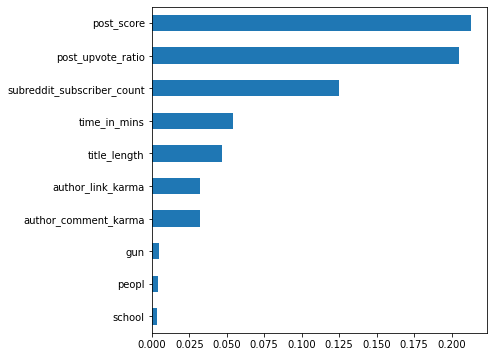

In [134]:
# Defining ranges for the hyperparameters to be scanned by the grid search
n_estimators = list(range(10,250,10))
max_depth = list(range(1, 25, 2)) 
rfscore2(df_subreddit_cvec,'target',0.25,n_estimators,max_depth)

> **Model 3**: KNN Gridsearch

**Can run knn gridsearch on small datasets but not for 10000+ datapoints. My machine is unable to take the load.**

Fitting 5 folds for each of 30 candidates, totalling 150 fits
GridSearch results
The best parameters on the training data are:

best n_neighbors: 5
best p: 2
best score is: 0.86

Confusion matrix:
[[  0  17]
 [  0 108]]


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


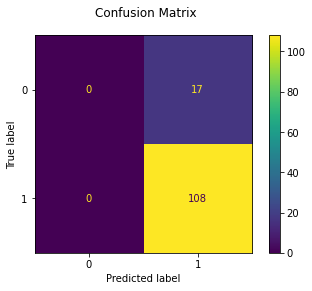

In [84]:
knnscore_gridsearch(df_subreddit_cvec[:500],'target',0.25)

> **Model 4**-KNeighborsClassifier without gridsearch

In [87]:
kf = KFold(n_splits=5, shuffle=True,random_state=42)
knn = KNeighborsClassifier(n_neighbors=19, p=2)
print("KNN Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(knn,df_subreddit_cvec.drop('target', axis=1),df['target'],cv=kf).mean(),
                                                           cross_val_score(knn,df_subreddit_cvec.drop('target', axis=1),df['target'],cv=kf).std() * 2))

KNN Score for Countvectorizer: 0.68 ± 0.02


In [88]:
knn = KNeighborsClassifier(n_neighbors=22, p=2)
print("KNN Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(knn,df_subreddit_cvec.drop('target', axis=1),df['target'],cv=kf).mean(),
                                                           cross_val_score(knn,df_subreddit_cvec.drop('target', axis=1),df['target'],cv=kf).std() * 2))

KNN Score for Countvectorizer: 0.68 ± 0.02


In [89]:
knn = KNeighborsClassifier(n_neighbors=27, p=2)
print("KNN Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(knn,df_subreddit_cvec.drop('target', axis=1),df['target'],cv=kf).mean(),
                                                           cross_val_score(knn,df_subreddit_cvec.drop('target', axis=1),df['target'],cv=kf).std() * 2))

KNN Score for Countvectorizer: 0.68 ± 0.02


> **Model 5**-Logistic regression

In [86]:
kf = KFold(n_splits=5, shuffle=True,random_state=42)
logreg = LogisticRegression(random_state=42)
print("Logreg Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(logreg,df_subreddit_cvec.drop('target', axis=1),df['target'],cv=kf).mean(),
                                                           cross_val_score(logreg,df_subreddit_cvec.drop('target', axis=1),df['target'],cv=kf).std() * 2))

Logreg Score for Countvectorizer: 0.73 ± 0.02


> **Model 6**: Using Ensemble methods

In [92]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

cv_kf = KFold(n_splits=10,
              shuffle=True,
              random_state=30113)

clf = DecisionTreeClassifier(random_state=42)
bagger = BaggingClassifier(clf, random_state=42)

base_scores_1 = cross_val_score(clf, df_subreddit_cvec.drop('target', axis=1),df['target'], cv=cv_kf)
ensemble_scores_1 = cross_val_score(bagger, df_subreddit_cvec.drop('target', axis=1),df['target'], cv=cv_kf)

print("DT: {:.2f} +/- {:.2f}".format(base_scores_1.mean(), 
                                     2 * base_scores_1.std()))
print("Bagging: {:.2f} +/- {:.2f}".format(ensemble_scores_1.mean(), 
                                          2 * ensemble_scores_1.std()))

DT: 0.75 +/- 0.02
Bagging: 0.79 +/- 0.03


>**Model 7**: Decision Stump

In [94]:
clf2 = DecisionTreeClassifier(max_depth=1,
                              random_state=42)
bagger = BaggingClassifier(clf2, 
                           random_state=42)

ensemble_scores = cross_val_score(bagger, df_subreddit_cvec.drop('target', axis=1),df['target'], cv=cv_kf)
print("Bagging: {:.2f} +/- {:.2f}".format(ensemble_scores.mean(),
                                          2 * ensemble_scores.std()))

Bagging: 0.73 +/- 0.04


## TfidfVectorizer()

In [96]:
tfid = TfidfVectorizer(stop_words='english',max_features=100, max_df=0.5)
tfid_X_data = tfid.fit_transform(df['post_title_processed'])
tfid_X  = pd.DataFrame(tfid_X_data.todense(),
                   columns=cvec.get_feature_names_out())

In [97]:
tfid_X.head()

,actual,ago,alway,anim,anyon,art,ask,away,babi,bad,...,video,wait,want,war,way,week,woman,work,world,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
tfid_X.columns

Index(['actual', 'ago', 'alway', 'anim', 'anyon', 'art', 'ask', 'away', 'babi',
       'bad', 'best', 'big', 'boy', 'cat', 'chang', 'child', 'come', 'cosplay',
       'day', 'dog', 'end', 'everi', 'fan', 'favorit', 'feel', 'final',
       'friend', 'fuck', 'game', 'girl', 'good', 'great', 'gun', 'guy', 'hand',
       'happi', 'hate', 'help', 'home', 'hope', 'hous', 'kid', 'kill', 'know',
       'let', 'life', 'like', 'littl', 'live', 'long', 'look', 'lose', 'love',
       'make', 'man', 'meme', 'mom', 'month', 'need', 'new', 'night', 'old',
       'peopl', 'photo', 'play', 'pleas', 'polic', 'post', 'real', 'realli',
       'right', 'run', 'say', 'school', 'shoot', 'someon', 'someth', 'star',
       'start', 'stop', 'tell', 'thank', 'thing', 'think', 'thought', 'time',
       'today', 'tri', 'turn', 'use', 'video', 'wait', 'want', 'war', 'way',
       'week', 'woman', 'work', 'world', 'year'],
      dtype='object')

## Concatenating tfidf dataframe with subreddit dummies

In [99]:
df_subreddit_tfidf=pd.concat([df_subreddit_dummies,tfid_X], axis=1)
df_subreddit_tfidf.shape
df_subreddit_tfidf.head()

,author_comment_karma,author_link_karma,time_in_mins,post_is_original_content,post_over_18,post_score,post_has_link,post_spoiler,post_stickied,subreddit_subscriber_count,...,video,wait,want,war,way,week,woman,work,world,year
0,15541,60892,665,0,0,47197,0,0,0,2536337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,58678,6272,682,0,0,20288,0,0,0,24719676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3302,6450,666,0,0,13857,0,0,0,21410219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,230,6754,748,0,0,20928,0,0,0,2315682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28965,6418,772,0,0,26027,0,0,0,1956757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
df_subreddit_tfidf.to_csv('Data/Subreddit dummies with Tfidf.csv')

> **Model 1**: Random Forest Classifier on Tfidf Vectorised data + subreddit dummies

The mean accuracy score is: 0.77

Confusion Matrix:

Predicted Values     0     1
Actual Values               
0                 1061   307
1                  327  1045
Features and their importance:

AxesSubplot(0.125,0.125;0.775x0.755)


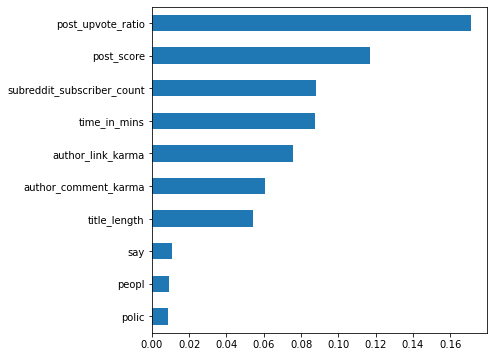

In [111]:
rfscore1(df_subreddit_tfidf,'target',0.25,25,10)

> **Model 2**: Gridsearch randomForest Classifier on tfidf vectorised data

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
GridSearch results
The best parameters on the training data are:
 {'max_depth': 23, 'n_estimators': 240}
best max_depth: 23
best n_estimators: 240
Random Forest Score: 0.78 +- 0.037

Confusion Matrix:

[[1084  284]
 [ 316 1056]]
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1368
           1       0.79      0.77      0.78      1372

    accuracy                           0.78      2740
   macro avg       0.78      0.78      0.78      2740
weighted avg       0.78      0.78      0.78      2740

0.781021897810219
Features and their importance:

AxesSubplot(0.125,0.125;0.775x0.755)


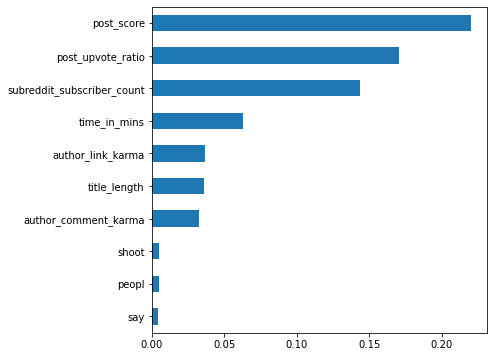

In [135]:
n_estimators = list(range(10,250,10))
max_depth = list(range(1, 25, 2)) 
rfscore2(df_subreddit_tfidf,'target',0.25,n_estimators,max_depth)

> **Model 3**: KNN Gridsearch

Fitting 5 folds for each of 30 candidates, totalling 150 fits
GridSearch results
The best parameters on the training data are:

best n_neighbors: 5
best p: 2
best score is: 0.86

Confusion matrix:
[[  0  17]
 [  0 108]]


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


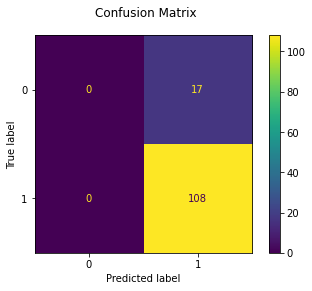

In [116]:
knnscore_gridsearch(df_subreddit_tfidf[:500],'target',0.25)

> **Model 4**-KNeighborsClassifier without gridsearch

In [117]:
kf = KFold(n_splits=5, shuffle=True,random_state=42)
knn = KNeighborsClassifier(n_neighbors=19, p=2)
print("KNN Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(knn,df_subreddit_tfidf.drop('target', axis=1),df['target'],cv=kf).mean(),
                                                           cross_val_score(knn,df_subreddit_tfidf.drop('target', axis=1),df['target'],cv=kf).std() * 2))

KNN Score for Countvectorizer: 0.68 ± 0.02


In [118]:
knn = KNeighborsClassifier(n_neighbors=22, p=2)
print("KNN Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(knn,df_subreddit_cvec.drop('target', axis=1),df['target'],cv=kf).mean(),
                                                           cross_val_score(knn,df_subreddit_cvec.drop('target', axis=1),df['target'],cv=kf).std() * 2))

KNN Score for Countvectorizer: 0.68 ± 0.02


In [119]:
knn = KNeighborsClassifier(n_neighbors=27, p=2)
print("KNN Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(knn,df_subreddit_cvec.drop('target', axis=1),df['target'],cv=kf).mean(),
                                                           cross_val_score(knn,df_subreddit_cvec.drop('target', axis=1),df['target'],cv=kf).std() * 2))

KNN Score for Countvectorizer: 0.68 ± 0.02


> **Model 5**-Logistic regression

In [120]:
kf = KFold(n_splits=5, shuffle=True,random_state=42)
logreg = LogisticRegression(random_state=42)
print("Logreg Score for Countvectorizer: %0.2f ± %0.2f" % (cross_val_score(logreg,df_subreddit_cvec.drop('target', axis=1),df['target'],cv=kf).mean(),
                                                           cross_val_score(logreg,df_subreddit_cvec.drop('target', axis=1),df['target'],cv=kf).std() * 2))

Logreg Score for Countvectorizer: 0.73 ± 0.02


> **Model 6**: Using Ensemble methods

In [121]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

cv_kf = KFold(n_splits=10,
              shuffle=True,
              random_state=30113)

clf = DecisionTreeClassifier(random_state=42)
bagger = BaggingClassifier(clf, random_state=42)

base_scores_1 = cross_val_score(clf, df_subreddit_cvec.drop('target', axis=1),df['target'], cv=cv_kf)
ensemble_scores_1 = cross_val_score(bagger, df_subreddit_cvec.drop('target', axis=1),df['target'], cv=cv_kf)

print("DT: {:.2f} +/- {:.2f}".format(base_scores_1.mean(), 
                                     2 * base_scores_1.std()))
print("Bagging: {:.2f} +/- {:.2f}".format(ensemble_scores_1.mean(), 
                                          2 * ensemble_scores_1.std()))

DT: 0.75 +/- 0.02
Bagging: 0.79 +/- 0.03


>**Model 7**: Decision Stump

In [122]:
clf2 = DecisionTreeClassifier(max_depth=1,
                              random_state=42)
bagger = BaggingClassifier(clf2, 
                           random_state=42)

ensemble_scores = cross_val_score(bagger, df_subreddit_cvec.drop('target', axis=1),df['target'], cv=cv_kf)
print("Bagging: {:.2f} +/- {:.2f}".format(ensemble_scores.mean(),
                                          2 * ensemble_scores.std()))

Bagging: 0.73 +/- 0.04


## Executive Summary

Conclusion points are as follows:

1. Bagging is giving the best score on the dataset followed by Random Forest Classifier with 
gridsearch and Decision Tree.

2. KNeighbors classifier with gridsearch is too burdensome for my system. The complexity of algorithms therefore should be considered into account while dealing with huge datasets.

3. KNeighbors classifier(without gridsearch) are giving almost comparable scores at 0.68 which is not that good but way above our baseline.

4. The respective scores of different models on both Tfidf vectorised and Countvectorized data are similar.

5. I had removed num_of_comments on post from X as including that would lead to leaking info in the target variable.

6. After analysing, I realised that time_in_min the post stays on hot thread may be very likely be highly correlated with number of comments, so another analysis after removing this variable should be done to see the results and compare.

7. My recommendations based on the analysis for a new post-
    -Post in a subreddit with high subscriber count.
    -The author's karma(link and comment) matters!(Eternal truth)
    -Have a decent title length
    -Politics, games, funny etc are popular topics. Tag them in your post.
    -Ask family, friends,co-workers and acquaintances to upvote your post. Try upvoting bots??

8. There seems to be a research design problem here, if we want to conclude whether a new post would be hot would require analysis on both hot and non-hot threads, but we are only considering hot threads here. So, the right conclusion here is assuming a new thread which we somehow know is a hot thread based on anaysis here, we can only predict whether it will be in the upper half of hot threads cutoff decided by median number of comments.